## Ingestion of Ethiopia births data from WorldPop

Source data: [https://www.worldpop.org/doi/10.5258/SOTON/WP00328](https://www.worldpop.org/doi/10.5258/SOTON/WP00328)

In [1]:
from shapely.geometry import Point
import geopandas as gpd
from osgeo import gdal
from osgeo import gdalconst
import pandas as pd

import rasterio
from rasterio.plot import show
import requests
import matplotlib.pyplot as plt
import numpy as np

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
d = rasterio.open('Ethiopia_1km_births/ETH_births_pp_v2_2015.tif')

In [3]:
print(d.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 1798, 'height': 1389, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0083333333, 0.0, 32.99958244782238,
       0.0, -0.0083333333, 14.899583643037253)}


In [4]:
print(d.bounds)

BoundingBox(left=32.99958244782238, bottom=3.3245836893372527, right=47.982915721222376, top=14.899583643037253)


In [5]:
array = d.read(1, masked=False)

In [6]:
log_array = np.log(array)

Text(0.5, 1.0, 'Ethiopia births per 1km (log scale)')

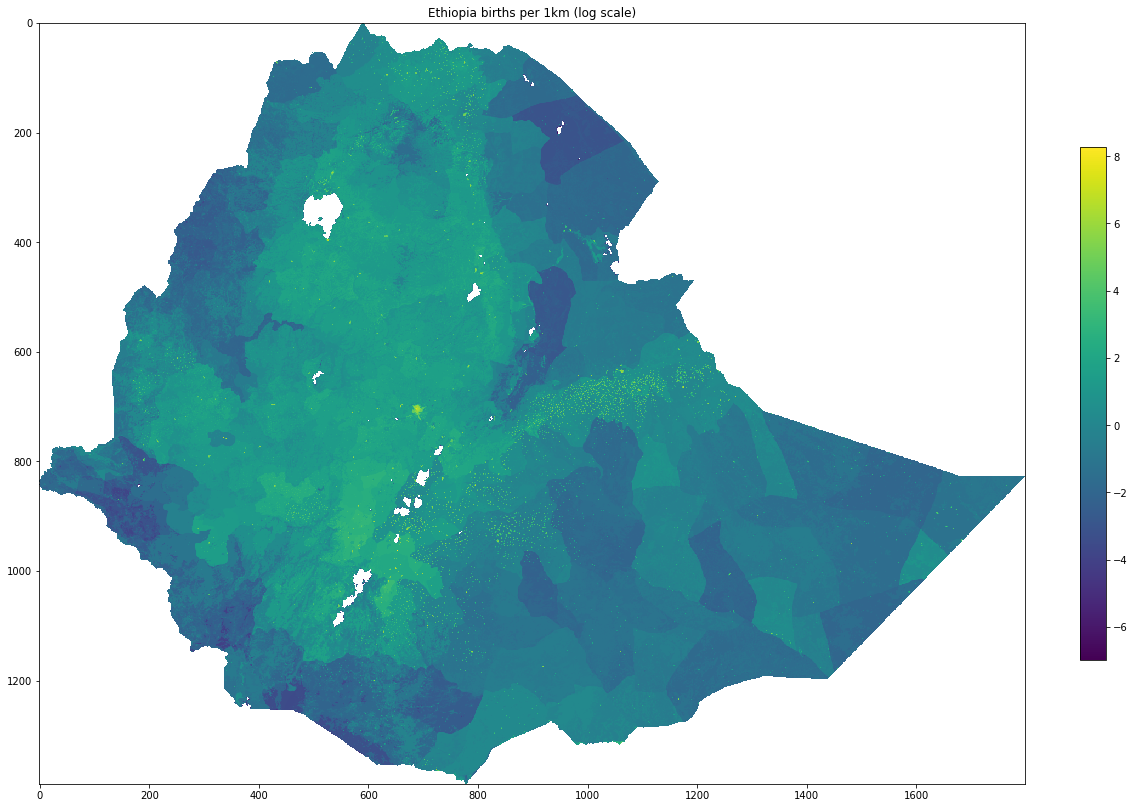

In [7]:
fig, ax = plt.subplots(figsize = (20,14))
chm_plot = ax.imshow(log_array, 
                     cmap='viridis')
fig.colorbar(chm_plot, fraction=0.023, ax=ax)
ax.set_title(f"Ethiopia births per 1km (log scale)")

## Convert to CSV

In [8]:
def raster2gpd(InRaster,feature_name,band=1,nodataval=-9999):
    '''
    Description: 
        Takes the path of a raster (.tiff) file and produces a Geopandas Data Frame.
    Params:
        - InRaster: the path of the input raster file
        - feature_name: the name of the feature represented by the pixel values 
    '''

    # open the raster and get some properties
    ds       = gdal.OpenShared(InRaster,gdalconst.GA_ReadOnly)
    GeoTrans = ds.GetGeoTransform()
    ColRange = range(ds.RasterXSize)
    RowRange = range(ds.RasterYSize)
    rBand    = ds.GetRasterBand(band) # first band
    nData    = rBand.GetNoDataValue()
    if nData == None:
        print(f"No nodataval found, setting to {nodataval}")
        nData = np.float32(nodataval) # set it to something if not set
    else:
        print(f"Nodataval is: {nData}")

    # specify the center offset (takes the point in middle of pixel)
    HalfX    = GeoTrans[1] / 2
    HalfY    = GeoTrans[5] / 2

    # Check that NoDataValue is of the same type as the raster data
    RowData = rBand.ReadAsArray(0,0,ds.RasterXSize,1)[0]
    if type(nData) != type(RowData[0]):
        print(f"NoData type mismatch: NoDataValue is type {type(nData)} and raster data is type {type(RowData[0])}")
        

    points = []
    for ThisRow in RowRange:
        RowData = rBand.ReadAsArray(0,ThisRow,ds.RasterXSize,1)[0]
        for ThisCol in ColRange:
            # need to exclude NaN values since there is no nodataval
            if (RowData[ThisCol] != nData) and not (np.isnan(RowData[ThisCol])):
                
                # TODO: implement filters on valid pixels
                # for example, the below would ensure pixel values are between -100 and 100
                #if (RowData[ThisCol] <= 100) and (RowData[ThisCol] >= -100):

                X = GeoTrans[0] + ( ThisCol * GeoTrans[1] )
                Y = GeoTrans[3] + ( ThisRow * GeoTrans[5] ) # Y is negative so it's a minus
                # this gives the upper left of the cell, offset by half a cell to get centre
                X += HalfX
                Y += HalfY

                points.append([Point(X, Y),X,Y,RowData[ThisCol],feature_name])

    return gpd.GeoDataFrame(points, columns=['geometry','longitude','latitude','feature_value','feature_name'])

In [9]:
gdf = raster2gpd('Ethiopia_1km_births/ETH_births_pp_v2_2015.tif','births')

Nodataval is: -3.4028230607370965e+38
NoData type mismatch: NoDataValue is type <class 'float'> and raster data is type <class 'numpy.float32'>


In [10]:
gdf.head()

,geometry,longitude,latitude,feature_value,feature_name
0,POINT (37.92042 14.89542),37.920416,14.895417,1.078747,births
1,POINT (37.91208 14.88708),37.912082,14.887084,1.065617,births
2,POINT (37.92042 14.88708),37.920416,14.887084,1.002735,births
3,POINT (37.92875 14.88708),37.928749,14.887084,1.159584,births
4,POINT (37.91208 14.87875),37.912082,14.878750,1.081665,births


In [11]:
gdf.shape

(1332373, 5)

### Join data with Admin shapes

In [12]:
admin = gpd.read_file('shapes/gadm36_ETH_shp/gadm36_ETH_3.shp')
admin['country'] = admin['NAME_0']
admin['state'] = admin['NAME_1']
admin['admin1'] = admin['NAME_1']
admin['admin2'] = admin['NAME_2']
admin['admin3'] = admin['NAME_3']
admin = admin[['geometry','country','state','admin1','admin2','admin3']]

In [13]:
gdf_ = gpd.sjoin(gdf, admin, how="left", op='intersects')

Remove NAs (outside Ethiopia):

In [14]:
gdf_ = gdf_.dropna(subset=['country'])

In [15]:
gdf_.head()

,geometry,longitude,latitude,feature_value,feature_name,index_right,country,state,admin1,admin2,admin3
42,POINT (37.93708 14.83708),37.937082,14.837084,0.769165,births,687.0,Ethiopia,Tigray,Tigray,Semien Mi'irabaw,Tahtay Adiyabo
52,POINT (37.92875 14.82875),37.928749,14.828750,0.774328,births,687.0,Ethiopia,Tigray,Tigray,Semien Mi'irabaw,Tahtay Adiyabo
53,POINT (37.93708 14.82875),37.937082,14.828750,0.781510,births,687.0,Ethiopia,Tigray,Tigray,Semien Mi'irabaw,Tahtay Adiyabo
54,POINT (37.94542 14.82875),37.945416,14.828750,0.788131,births,687.0,Ethiopia,Tigray,Tigray,Semien Mi'irabaw,Tahtay Adiyabo
55,POINT (37.95375 14.82875),37.953749,14.828750,0.751098,births,687.0,Ethiopia,Tigray,Tigray,Semien Mi'irabaw,Tahtay Adiyabo


In [16]:
gdf_.shape

(1326943, 11)

In [17]:
gdf_ = gdf_[['feature_name','feature_value','country','admin1','admin2','admin3', 'geometry']]

gdf_ = gdf_.rename(columns={'feature_value': 'value','feature_name':'variable_id', 'geometry': 'coordinate'})

gdf_['main_subject'] = gdf_['country']

gdf_['time'] = '2015-01-01T00:00:00'
gdf_['time_precision'] = 'year'

In [30]:
gdf_.head()

,variable_id,value,country,admin1,admin2,admin3,coordinate,main_subject,time,time_precision
42,births,0.769165,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.93708 14.83708),Ethiopia,2015-01-01T00:00:00,year
52,births,0.774328,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.92875 14.82875),Ethiopia,2015-01-01T00:00:00,year
53,births,0.781510,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.93708 14.82875),Ethiopia,2015-01-01T00:00:00,year
54,births,0.788131,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.94542 14.82875),Ethiopia,2015-01-01T00:00:00,year
55,births,0.751098,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.95375 14.82875),Ethiopia,2015-01-01T00:00:00,year


In [34]:
gdf_for_t2wml = gdf_[['country','value','admin1','admin2','admin3','coordinate','time','time_precision']]
gdf_for_t2wml = gdf_for_t2wml.rename(columns={'value':'total_births'})

In [36]:
gdf_for_t2wml.head()

,country,total_births,admin1,admin2,admin3,coordinate,time,time_precision
42,Ethiopia,0.769165,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.93708 14.83708),2015-01-01T00:00:00,year
52,Ethiopia,0.774328,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.92875 14.82875),2015-01-01T00:00:00,year
53,Ethiopia,0.781510,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.93708 14.82875),2015-01-01T00:00:00,year
54,Ethiopia,0.788131,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.94542 14.82875),2015-01-01T00:00:00,year
55,Ethiopia,0.751098,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,POINT (37.95375 14.82875),2015-01-01T00:00:00,year


### Aggregate by Admin3

In [38]:
df_sum = pd.DataFrame(\
                  gdf_for_t2wml.groupby([
                                'country',
                                'admin1',
                                'admin2',
                                'admin3',
                                'time',
                                'time_precision'])\
                  .total_births.sum())\
                  .reset_index()

In [44]:
df_avg = pd.DataFrame(\
                  gdf_for_t2wml.groupby([
                                'country',
                                'admin1',
                                'admin2',
                                'admin3',
                                'time',
                                'time_precision'])\
                  .total_births.mean())\
                  .reset_index()

In [46]:
df_combined = df_sum.join(df_avg, how='left', rsuffix='_avg')\
#            [['country','admin1','admin2','admin3','time','time_precicision','total_births','total_births_avg']]

In [47]:
df_combined

,country,admin1,admin2,admin3,time,time_precision,total_births,country_avg,admin1_avg,admin2_avg,admin3_avg,time_avg,time_precision_avg,total_births_avg
0,Ethiopia,Addis Abeba,Addis Abeba,Addis Ketema,2015-01-01T00:00:00,year,6787.842529,Ethiopia,Addis Abeba,Addis Abeba,Addis Ketema,2015-01-01T00:00:00,year,848.480316
1,Ethiopia,Addis Abeba,Addis Abeba,Akaki - Kalit,2015-01-01T00:00:00,year,3202.189567,Ethiopia,Addis Abeba,Addis Abeba,Akaki - Kalit,2015-01-01T00:00:00,year,21.491205
2,Ethiopia,Addis Abeba,Addis Abeba,Arada,2015-01-01T00:00:00,year,6011.952667,Ethiopia,Addis Abeba,Addis Abeba,Arada,2015-01-01T00:00:00,year,601.195267
3,Ethiopia,Addis Abeba,Addis Abeba,Bole,2015-01-01T00:00:00,year,5616.444940,Ethiopia,Addis Abeba,Addis Abeba,Bole,2015-01-01T00:00:00,year,36.470422
4,Ethiopia,Addis Abeba,Addis Abeba,Gulele,2015-01-01T00:00:00,year,7837.595625,Ethiopia,Addis Abeba,Addis Abeba,Gulele,2015-01-01T00:00:00,year,206.252516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,Ethiopia,Tigray,Semien Mi'irabaw,Laelay Adiyabo,2015-01-01T00:00:00,year,4397.237500,Ethiopia,Tigray,Semien Mi'irabaw,Laelay Adiyabo,2015-01-01T00:00:00,year,2.058632
686,Ethiopia,Tigray,Semien Mi'irabaw,Medebay Zana,2015-01-01T00:00:00,year,5489.342918,Ethiopia,Tigray,Semien Mi'irabaw,Medebay Zana,2015-01-01T00:00:00,year,4.308746
687,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,2015-01-01T00:00:00,year,3999.693164,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,2015-01-01T00:00:00,year,1.016699
688,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Koraro,2015-01-01T00:00:00,year,4965.784532,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Koraro,2015-01-01T00:00:00,year,6.130598


In [26]:
df2

,variable_id,country,admin1,admin2,admin3,main_subject,time,time_precision,value
0,births,Ethiopia,Addis Abeba,Addis Abeba,Addis Ketema,Ethiopia,2015-01-01T00:00:00,year,848.480316
1,births,Ethiopia,Addis Abeba,Addis Abeba,Akaki - Kalit,Ethiopia,2015-01-01T00:00:00,year,21.491205
2,births,Ethiopia,Addis Abeba,Addis Abeba,Arada,Ethiopia,2015-01-01T00:00:00,year,601.195267
3,births,Ethiopia,Addis Abeba,Addis Abeba,Bole,Ethiopia,2015-01-01T00:00:00,year,36.470422
4,births,Ethiopia,Addis Abeba,Addis Abeba,Gulele,Ethiopia,2015-01-01T00:00:00,year,206.252516
...,...,...,...,...,...,...,...,...,...
685,births,Ethiopia,Tigray,Semien Mi'irabaw,Laelay Adiyabo,Ethiopia,2015-01-01T00:00:00,year,2.058632
686,births,Ethiopia,Tigray,Semien Mi'irabaw,Medebay Zana,Ethiopia,2015-01-01T00:00:00,year,4.308746
687,births,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Adiyabo,Ethiopia,2015-01-01T00:00:00,year,1.016699
688,births,Ethiopia,Tigray,Semien Mi'irabaw,Tahtay Koraro,Ethiopia,2015-01-01T00:00:00,year,6.130598


In [ ]:
df.to_csv('Ethiopia_births.csv', index=False)